In [3]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from PIL import Image, ImageSequence
import os

import seaborn as sea
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline

sea.set(style="white")

In [5]:
def create_loss_manifold(sigfrac, m1, m2, z):

    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)

    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))

    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])

    x = w1_values
    y = w2_values
    z = loss_values

    sea.set(style="whitegrid")
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='r', marker='.', alpha = 0.1)
    ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('W1')
    ax.set_ylabel('W2')
    ax.set_zlabel('Loss')
    ax.set_title("Loss Manifold m1: {} m2: {} sigfrac: {}".format(m1, m2, np.round(sigfrac, 4)))

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_zticks([])
    
    ax.view_init(elev=50, azim=10)
    #plt.savefig('plot.png', dpi=450, bbox_inches='tight')
    return ax

In [3]:
z = np.load("z_2param15.56test.npy", allow_pickle = True).item()
z.keys()

dict_keys([(0.001, 1, 5.5), (0.1, 1, 5.5)])

<Axes3D: title={'center': 'Loss Manifold m1: 1 m2: 5.5 sigfrac: 0.1'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

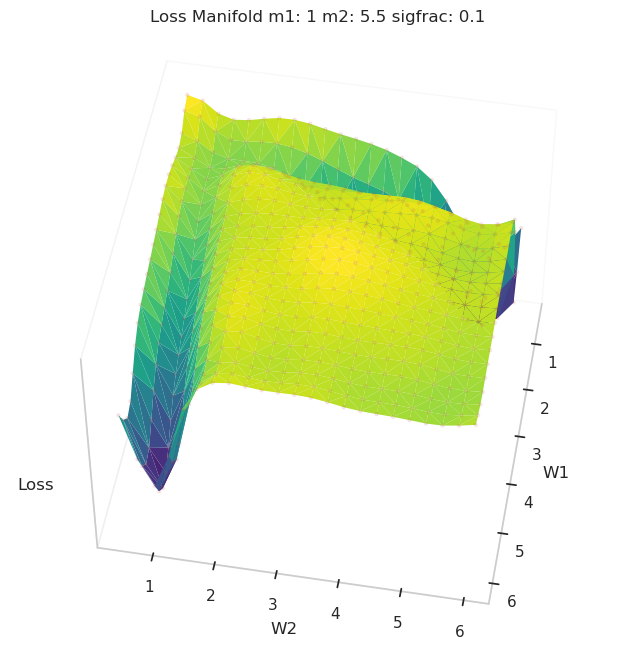

In [8]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[19], 1, 5.5, z_allm1m2_6HD)

<Axes3D: title={'center': 'Loss Manifold m1: 3 m2: 3 sigfrac: 0.001'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

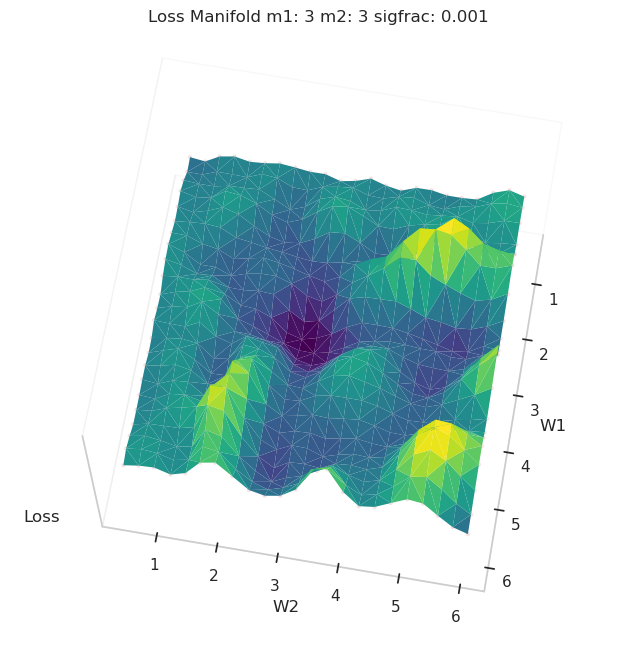

In [20]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(sig_space[0], 3, 3, z_allm1m2_6HD)

<Axes3D: title={'center': 'Loss Manifold m1: 3.5 m2: 5.5 sigfrac: 0.001'}, xlabel='W1', ylabel='W2', zlabel='Loss'>

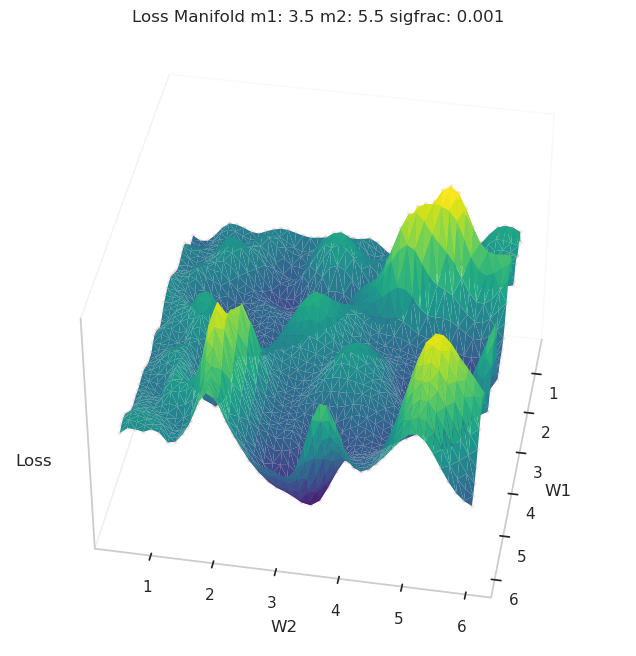

In [12]:
sig_space = np.logspace(-3, -1 , 20)
create_loss_manifold(0.001, 3.5, 5.5, z_allm1m2_6HD)

In [43]:
def loss_landscape_nofit(sigfrac, m1, m2, z):
    
    #create grid of points for the model to be evaluated at
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    grid_axes = []
    for w1 in weight_list:
        for w2 in weight_list:
            grid_axes.append((w1, w2))
            
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(w1_values, w2_values, bins=(23,23), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    #plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    plt.savefig('plot2D.png', dpi=450, bbox_inches='tight')
    return h

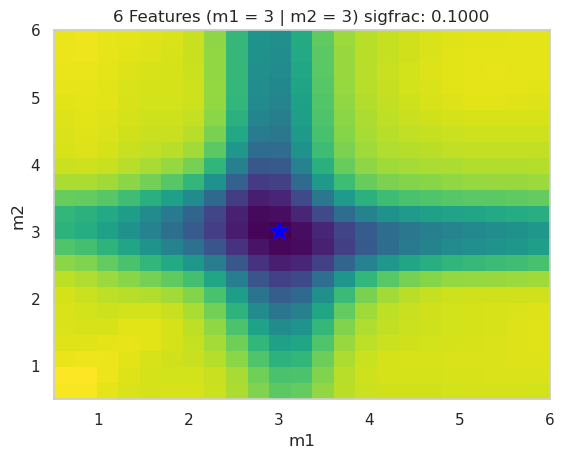

In [44]:
loss_landscape_nofit(0.1, 3, 3, z_allm1m2_6HD);

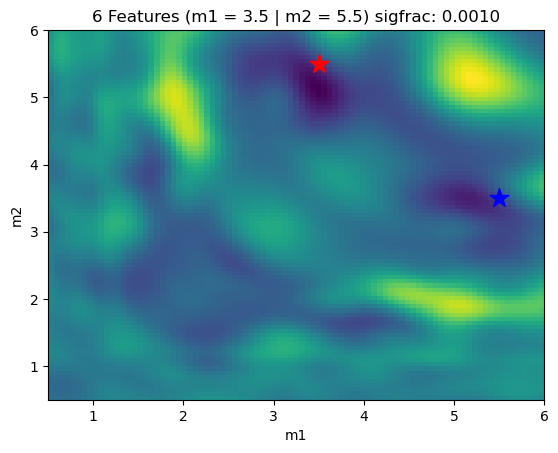

In [26]:
loss_landscape_nofit(0.001, 3.5, 5.5, z_allm1m2_6HDER);

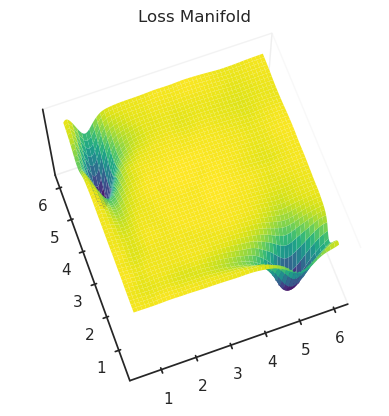

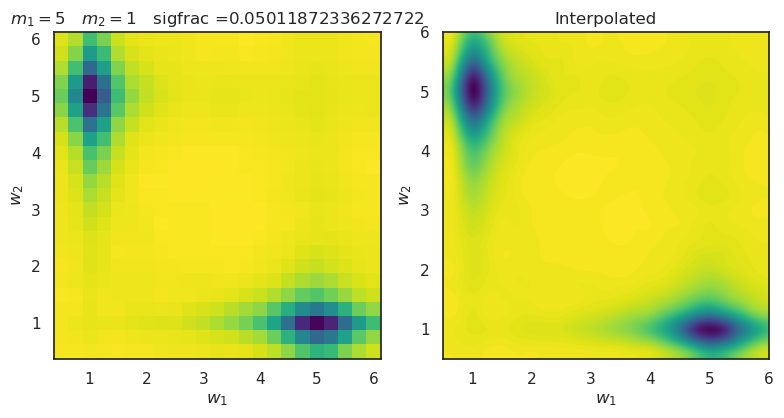

In [17]:
def plot_interpolated_landscape(sigfrac, m1, m2, z, step, decay):
    
    decay = decay
    start = 0.5
    end = 6
    step = step

    weight_list = np.arange(start, end + step, step)

    x_values = weight_list
    y_values = weight_list

    x, y = np.meshgrid(x_values, y_values)

    loss_values_flat = z[sigfrac, m1, m2, decay]
    loss_values = np.array(loss_values_flat).reshape(x.shape)

    interp_spline = RectBivariateSpline(x_values, y_values, loss_values, s = 0)

    xi, yi = np.meshgrid(np.linspace(min(x_values), max(x_values), 1000), np.linspace(min(y_values), max(y_values), 1000))
    zi = interp_spline(xi[0, :], yi[:, 0])
    
    #3d projection
    fig = plt.figure()
    ax3d = fig.add_subplot(111, projection='3d')
    ax3d.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', linewidth = 0)
    ax3d.set_title("Loss Manifold")
    ax3d.xaxis.pane.fill = False
    ax3d.yaxis.pane.fill = False
    ax3d.zaxis.pane.fill = False

    ax3d.grid(False)
    
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax3d.set_zticks([])
    ax3d.view_init(elev=70, azim=250)

    #2d projection
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    ax[0].pcolormesh(x, y, loss_values, cmap='viridis')
    ax[0].set_aspect("equal")
    ax[0].set_title(f"$m_{1} = {m1} \quad m_{2} = {m2} \quad$" + f"sigfrac ={sigfrac}")
    ax[0].set_xlabel(r"$w_{1}$")
    ax[0].set_ylabel(r"$w_{2}$")

    ax[1].contourf(xi, yi, zi, cmap='viridis', levels = 100)
    ax[1].set_aspect("equal")
    ax[1].set_title('Interpolated'.format(m1, m2, sigfrac))
    ax[1].set_xlabel(r"$w_{1}$")
    ax[1].set_ylabel(r"$w_{2}$")

    plt.tight_layout()
    #plt.savefig('interpolation3.55.5.png', dpi=450, bbox_inches='tight')
    return fig

z = np.load("data/landscapes/z_6_3_51_0.25_qq_extra_decent-sun-87qq_False.npy", allow_pickle = True).item()
sigspace = np.logspace(-3.5, -1.3, 10)
plot_interpolated_landscape(sigspace[9], 5, 1, z, 0.25, "qq")
plt.show()

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image,ImageSequence
from IPython.display import clear_output
def create_gif_manifold(sigspace, m1, m2, z, step, elv, azim, save = False):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sigspace = sigspace
    
    frames = []
    for sig in sigspace:
        
        print(sig)
        fig = plt.figure(figsize = (10,8))
        #ax = fig.add_subplot(111, projection='3d')
        ax = create_3D_loss_manifold(sig, m1, m2, z, step, elv, azim, save)

        image_path = os.path.join(output_directory, f'hist_{sig}.png')
        plt.savefig(image_path, dpi = 450, bbox_inches='tight')
        plt.close(fig)
        clear_output(wait=True)

        frames.append(Image.open(image_path))

    output_gif_filename = f'LossManifoldformated_HighRes6{m1}{m2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)
    
    plt.savefig('plot.png', dpi=450, bbox_inches='tight')